# RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

- Author: [Yoonji Oh](https://github.com/samdaseuss)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

### Welcome to the RAPTOR Tutorial!
In this tutorial, we’ll explore RAPTOR, which stands for Recursive Abstractive Processing for Tree-Organized Retrieval. This innovative technique organizes data into a tree-like structure through summarization, making it easier to efficiently locate the information you need. The search process begins at the root and navigates down to more detailed nodes, ultimately delivering the most relevant answer to your query.

This tutorial is inspired by the paper "RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval". A special thanks to the authors for their groundbreaking work that inspired this deep dive. Let’s get started!


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Installation](#installation)
- [What is RAPTOR?](#what-is-raptor)
- [Documents](#documents)
- [Models](#models)
- [Tree Construction](#tree-construction)


### References

- [RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval](https://arxiv.org/pdf/2401.18059)  
  **Authors**: Xinyu Zhang, Tao Lei, Heng Ji, Kevin Small  
  **Published in**: *arXiv preprint arXiv:2401.18059* (2024)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [114]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

In [115]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval"
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [116]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Installation

To proceed with this tutorial, you'll need to install the following packages: `langchain`, `umap-learn`, `scikit-learn`, `langchain_community`, `tiktoken`, `langchain-openai`, `langchainhub`, `chromadb`, `langchain-anthropic` and `matplotlib`. You can install them all at once using the command below:

In [5]:
%pip install -qU langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic matplotlib 

### Package List

1. **langchain** ([Github](https://github.com/langchain-ai/langchain)) - LangChain is a framework for developing applications powered by large language models (LLMs).

2. **umap-learn** ([Github](https://github.com/lmcinnes/umap)) - Uniform Manifold Approximation and Projection (UMAP) is a dimensionality reduction technique that can be used for visualization, similar to t-SNE, but also for general non-linear dimensionality reduction. UMAP depends on scikit-learn and its dependencies like numpy and scipy. UMAP also requires numba for performance reasons.

3. **scikit-learn** ([Github](https://github.com/scikit-learn/scikit-learn)) - scikit-learn is a Python module for machine learning built on top of SciPy and distributed under the 3-Clause BSD license. If you want to use the `umap-learn` library, this module is highly recommended.

4. **langchain_community** - An extension package provided by the LangChain community, including tools and resources created by the community.

5. **tiktoken** ([Github](https://github.com/openai/tiktoken)) - tiktoken is a fast BPE tokenizer designed for use with OpenAI's models. Language models do not interpret text as we do; instead, they process a sequence of numbers (tokens). Byte pair encoding (BPE) is a method for converting text into tokens.

6. **langchain-openai** ([Github](https://github.com/langchain-ai/langchain/blob/master/docs/docs/integrations/providers/openai.mdx)) - A package that integrates LangChain with OpenAI APIs to leverage OpenAI's language models within LangChain workflows.

7. **langchainhub** - LangChain's "Hub" enables the sharing and reuse of various LangChain components (e.g., chains, agents).

8. **chromadb** ([Visit](https://www.trychroma.com/), [Github](https://github.com/chroma-core/chroma)) - Chroma is an open-source AI application database with built-in features for AI model workflows.

9. **langchain-anthropic** ([Docs](https://python.langchain.com/docs/integrations/providers/anthropic/)) - A package to integrate LangChain with Anthropic APIs, allowing access to language models like Claude through LangChain.

10. **matplotlib** ([Github](https://github.com/matplotlib/matplotlib)) - matplotlib is a popular library for creating static, animated, and interactive visualizations in Python.

## What is RAPTOR?

RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval  
The RAPTOR paper introduces an intriguing approach to indexing and retrieving documents.

- **Leafs** represent the initial set of documents.
- The leafs are embedded and clustered.
- Then, the clusters are summarized at a higher (more abstract) level to capture information across similar documents.  
  This process is performed recursively, forming a "tree" that progresses from the original documents (leafs) to more abstract summaries.

This approach can be applied at various scales. Leafs can be:

- Text chunks within a single document (as shown in the paper)
- Entire documents (as shown below)  
With longer-context LLMs, this can be extended to entire documents.

---

## Documents

Let’s apply this concept to LangChain's LCEL documentation.

In this case, each document is a unique web page from the LCEL documentation.

The context sizes range from fewer than 2,000 tokens to over 10,000 tokens.

The process describes extracting text data from web documents and calculating the token count of the text, which is visualized in a histogram.

1. **Token Counting**:  
   - Use the `tiktoken` library to calculate the number of tokens in a string based on a given encoding name.
2. **Recursive URL Loading**:  
   - Use the `RecursiveUrlLoader` class to recursively load web documents from specified URLs.  
   - Extract text from HTML documents using BeautifulSoup during this process.
3. **Aggregating Text Data**:  
   - Load documents from multiple URLs and combine all text data into a single list.
4. **Token Calculation**:  
   - Call the `num_tokens_from_string` function for each document text to calculate the number of tokens, then store the results in a list.
5. **Histogram Visualization**:  
   - Use `matplotlib` to visualize the distribution of token counts in a histogram.  
   - The histogram plots token counts on the x-axis and the frequency of documents with that token count on the y-axis.

A histogram helps to understand the distribution of data, especially for visually identifying the length distribution of the text data.

In [117]:
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
import tiktoken
import matplotlib.pyplot as plt

In [118]:
# Returns the number of tokens in the given string.
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [119]:
# Loading LCEL Documents
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

In [120]:
# Loading LCEL Documents Using PydanticOutputParser (External LCEL Documents)
url = "https://python.langchain.com/docs/how_to/output_parser_structured/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

In [121]:
# Loading External LCEL Documents Using Self-Query Retriever
url = "https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

In [122]:
# Document Text
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

In [123]:
# Calculating Token Count for Each Document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

<function matplotlib.pyplot.show(close=None, block=None)>

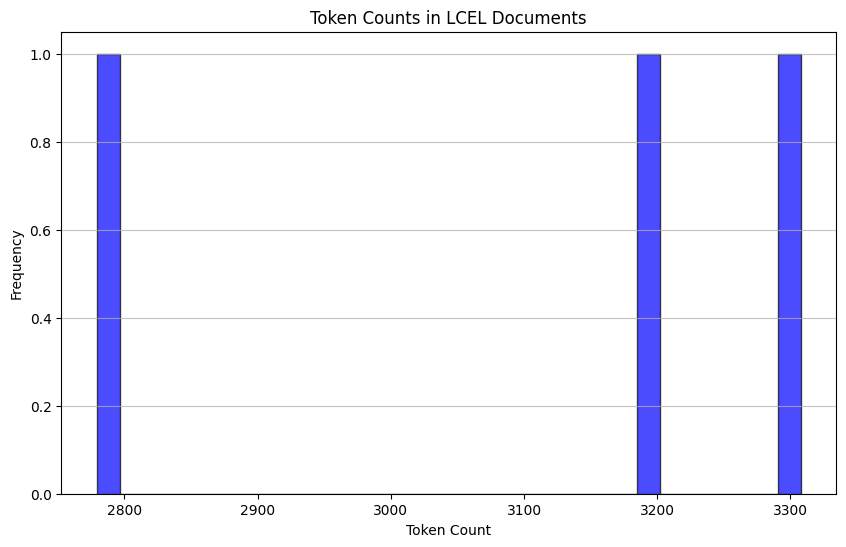

In [124]:
# Plotting a Histogram of Token Counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Counts in LCEL Documents")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Displaying the Histogram
plt.show


Explaining the Process of Sorting, Concatenating Document Text, and Calculating Token Count

- The documents (`docs`) are sorted based on the value of the "source" key in their metadata.
- The sorted list of documents is then reversed.
- The text content of the reversed documents is concatenated using a specific delimiter (`"\n\n\n --- \n\n\n"`).
- The number of tokens in the concatenated text is calculated using the `num_tokens_from_string` function and printed. The "cl100k_base" model is used for tokenization.

In [125]:
# Concatenating Document Text
# Sorting documents based on source metadata.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))  # Reversing the order of the sorted documents.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [
        # Concatenating the content of the reversed documents.
        doc.page_content
        for doc in d_reversed
    ]
)
print(
    "Num tokens in all context: %s"  # Printing the total token count across all contexts.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 9282


Explaining the Process of Splitting Text Using `RecursiveCharacterTextSplitter`

- Set the `chunk_size_tok` variable to specify the size of each text chunk as 2000 tokens.
- Initialize the text splitter using the `from_tiktoken_encoder` method of `RecursiveCharacterTextSplitter`. Set the `chunk_size` to 2000 and the `chunk_overlap` to 0 to ensure there is no overlap between chunks.
- Call the `split_text` method of the initialized text splitter to split the concatenated text stored in the `concatenated_content` variable. The split results are stored in the `texts_split` variable.

In [126]:
# Code for Text Splitting
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000  # Set the chunk size for tokens.  
# Initialize the recursive character text splitter and configure the chunk size and overlap using a token encoder.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(
    concatenated_content
)  # Split the given text.

## Models

Various models can be tested, including the new Claude3 series.

Don’t forget to set the relevant API keys:
- `OPENAI_API_KEY` for OpenAI and `ANTHROPIC_API_KEY` for Anthropic if using their services.

Implement a chatbot model using `ChatOpenAI` or `ChatAnthropic` with `OpenAIEmbeddings`.

- Instantiate `OpenAIEmbeddings` to initialize OpenAI's embedding functionality.
- Use `ChatOpenAI` or `ChatAnthropic` to initialize the chatbot model, setting the temperature to 0.

In [127]:
from dotenv import load_dotenv

load_dotenv()

True

The following code illustrates how to set up `Cache Embedding` using `LangChain`. It prevents redundant embedding calculations for identical inputs by storing and reusing cached values.

In [128]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# Defines a local directory to store cached data.
store = LocalFileStore("./cache/")

# Initializing the Embedding Instance
embd = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

# Combining Cache Backend with Embeddings
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embd, # The OpenAIEmbeddings instance that performs the embedding calculations.
    store, # The LocalFileStore instance where cache data is saved.
    namespace=embd.model # Assigns the embedding model's name as the namespace for cached data to avoid conflicts with other models.
)

The following code demonstrates how to initialize ChatOpenAI and ChatAnthropic models using LangChain and utilize streaming functionality to output results token by token.

In [129]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.callbacks.base import BaseCallbackHandler

# Define a custom callback class to handle token streaming.
# This class inherits from LangChain's BaseCallbackHandler and is used to print each token as it is generated.
class StreamCallback(BaseCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs):
        # Print each token without adding a new line, ensuring real-time display of the generated text.
        print(token, end="", flush=True)

# Initialize the ChatOpenAI model.
# This configuration uses OpenAI's GPT model ("gpt-4-turbo-preview").
# The temperature is set to 0 to produce deterministic outputs with minimal variability.
# Streaming is enabled to allow real-time generation of text.
# The StreamCallback is passed to handle the streaming of tokens.
model = ChatOpenAI(
    model="gpt-4-turbo-preview",  # Specify the OpenAI model to use.
    temperature=0,               # Set the temperature for deterministic output.
    streaming=True,              # Enable streaming for real-time token generation.
    callbacks=[StreamCallback()],  # Attach the custom StreamCallback for token streaming.
)

# ==============================================================================
# ChatAnthropic Model Initialization (Optional)
# ------------------------------------------------------------------------------
# Uncomment the following section to initialize the ChatAnthropic model instead 
# of ChatOpenAI. This configuration uses Anthropic's Claude model 
# ("claude-3-opus-20240229"). The temperature is similarly set to 0 for 
# deterministic output.
#
# Note: ChatAnthropic is currently commented out and can be enabled as needed.
# ==============================================================================

# model = ChatAnthropic(
#     temperature=0,              # Set the temperature for deterministic output.
#     model="claude-3-opus-20240229"  # Specify the Anthropic model to use.
# )


## Tree Construction

The clustering approach used in tree construction includes several intriguing ideas.

### GMM (Gaussian Mixture Model)

- Models the distribution of data points across various clusters.
- Determines the optimal number of clusters by evaluating the model's Bayesian Information Criterion (BIC).

### UMAP (Uniform Manifold Approximation and Projection)

- Supports clustering.
- Reduces the dimensionality of high-dimensional data.
- UMAP emphasizes natural groupings based on the similarity of data points.

### Local and Global Clustering

- Used to analyze data at different scales.
- Effectively captures both fine-grained patterns and broader trends within the data.

### Thresholding

- Applied to determine cluster membership in the context of GMM.
- Based on probabilistic distributions (assigning data points to ≥ 1 cluster).

---------

The code for GMM and thresholding is credited to Sarthi et al., as mentioned in the following sources:

- [Original Repository](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
- [Minor Adjustments](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

Full credit is given to both authors.

The `global_cluster_embeddings` function uses UMAP for global dimensionality reduction of embeddings.

- Reduces the dimensionality of the input embeddings to the specified dimension (`dim`) using UMAP.
- `n_neighbors` specifies the number of neighbors to consider for each point and defaults to the square root of the number of embeddings if not provided.
- `metric` specifies the distance metric to be used by UMAP.
- The result is a numpy array of embeddings reduced to the specified dimensions.

In [130]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap.umap_ as umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # Fixed seed value for reproducibility

### --- Added comments and documentation to the referenced code above --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Performs global dimensionality reduction of embeddings using UMAP.

    Parameters:
    - embeddings: Input embeddings as a numpy array.
    - dim: Target dimensionality of the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   Defaults to the square root of the number of embeddings if not provided.
    - metric: The distance metric to use with UMAP.

    Returns:
    - A numpy array of embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

The function `local_cluster_embeddings` is implemented to perform local dimensionality reduction on embedding data.

- The input embeddings (`embeddings`) are reduced to the specified dimension (`dim`) using UMAP.
- During the dimensionality reduction process, the number of neighbors to consider for each point (`num_neighbors`) and the distance metric (`metric`) are used as parameters.
- Finally, the reduced embeddings are returned as a numpy array.

In [131]:
def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Performs local dimensionality reduction on embeddings. 
    This is typically used after global clustering.

    Parameters:
    - embeddings: Input embeddings as a numpy array.
    - dim: Target dimensionality of the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use with UMAP.

    Returns:
    - A numpy array of embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


The `get_optimal_clusters` function is used to determine the optimal number of clusters based on the given embedding data. This is achieved by calculating the Bayesian Information Criterion (BIC) using the Gaussian Mixture Model (GMM).

- The input embeddings are provided as a numpy array.
- The maximum number of clusters (`max_clusters`) specifies the upper limit for the number of clusters to consider. The default value is 50.
- A fixed `random_state` is used to ensure reproducibility.
- The function iterates through multiple cluster numbers for the input embeddings and calculates the BIC value for each.
- The number of clusters with the lowest BIC value is determined to be the optimal number of clusters and is returned.
  
This function is particularly useful for automatically finding the number of clusters that best describe the data in a clustering problem.

In [132]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determines the optimal number of clusters using the Gaussian Mixture Model (GMM)
    and the Bayesian Information Criterion (BIC).

    Parameters:
    - embeddings: Input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: A seed value for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters.
    """
    max_clusters = min(
        max_clusters, len(embeddings)
    )  # Set the maximum number of clusters to the smaller of max_clusters or the length of embeddings.
    n_clusters = np.arange(1, max_clusters)  # Generate a range of cluster numbers from 1 to max_clusters.
    bics = []  # List to store BIC scores.
    for n in n_clusters:  # Iterate through each cluster number.
        gm = GaussianMixture(
            n_components=n, random_state=random_state
        )  # Initialize a Gaussian Mixture Model with n components.
        gm.fit(embeddings)  # Fit the model to the embeddings.
        bics.append(gm.bic(embeddings))  # Add the BIC score of the fitted model to the list.
    return n_clusters[np.argmin(bics)]  # Return the cluster number with the lowest BIC score.


The `GMM_cluster` function performs clustering on embeddings using a Gaussian Mixture Model (GMM). This process is based on a probability threshold.

- The input embeddings are provided as a numpy array.
- The `threshold` parameter specifies the probability threshold for assigning embeddings to specific clusters.
- `random_state` is used to ensure reproducibility of the results.
- The `get_optimal_clusters` function is called to determine the optimal number of clusters.
- Based on the determined number of clusters, a Gaussian Mixture Model is initialized and trained on the input embeddings.
- Cluster assignment probabilities are calculated for each embedding, and embeddings are assigned to clusters if their probability exceeds the given threshold.
- The function returns a tuple containing the cluster labels for the embeddings and the determined number of clusters.

In [133]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Clusters embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: Input embeddings as a numpy array.
    - threshold: Probability threshold for assigning embeddings to clusters.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the determined number of clusters.
    """
    n_clusters = get_optimal_clusters(embeddings)  # Determine the optimal number of clusters.
    # Initialize the Gaussian Mixture Model.
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)  # Train the model on the embeddings.
    probs = gm.predict_proba(
        embeddings
    )  # Predict the probabilities of each embedding belonging to each cluster.
    # Select clusters as labels where the probabilities exceed the threshold.
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters  # Return the labels and the number of clusters.



The `perform_clustering` function performs dimensionality reduction, global clustering using a Gaussian Mixture Model (GMM), and local clustering within each global cluster to return clustering results.

- **Dimensionality Reduction**: The input embeddings are reduced to a specified dimension (`dim`) using UMAP. This step prepares the embeddings for further clustering processes.
- **Global Clustering**: Global clustering is performed on the reduced embeddings using a Gaussian Mixture Model (GMM). Cluster assignments are determined based on a specified probability threshold (`threshold`).
- **Local Clustering**: Additional local clustering is performed within each global cluster. This involves applying dimensionality reduction and GMM clustering to embeddings that belong to each global cluster, based on the results of the global clustering.
- **Final Output**: The function assigns global and local cluster IDs to all embeddings and returns a list of cluster IDs. This list contains the cluster assignments for each embedding in the order they appear.

This function combines global and local clustering approaches to handle high-dimensional data, providing more granular clustering results. It is particularly effective for analyzing complex data structures and uncovering hierarchical patterns within the data.

In [134]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Performs dimensionality reduction, clustering using a Gaussian Mixture Model (GMM),
    and local clustering within each global cluster, in sequence.

    Parameters:
    - embeddings: Input embeddings as a numpy array.
    - dim: Target dimensionality for UMAP reduction.
    - threshold: Probability threshold for assigning embeddings to clusters in GMM.

    Returns:
    - A list of numpy arrays containing cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Skip clustering if there is insufficient data.
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters by direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Perform local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for already processed total clusters
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


Implement the function `embed` to generate embeddings for a list of text documents.

- Takes a list of text documents (`texts`) as input.
- Uses the `embed_documents` method of the `embd` object to generate embeddings for the text documents.
- Converts the generated embeddings into a `numpy.ndarray` format and returns it.

In [135]:
def embed(texts):
    # Generates embeddings for a list of text documents.
    #
    # This function assumes that the `embd` object exists, which has a method
    # `embed_documents` that takes a list of texts and returns their embeddings.
    #
    # Parameters:
    # - texts: List[str], a list of text documents to be embedded.
    #
    # Returns:
    # - numpy.ndarray: An array of embeddings for the given text documents.
    text_embeddings = embd.embed_documents(
        texts
    )  # Generate embeddings for the text documents.
    text_embeddings_np = np.array(text_embeddings)  # Convert the embeddings to a numpy array.
    return text_embeddings_np  # Return the embedded numpy array.



The `embed_cluster_texts` function embeds and clusters a list of texts, returning a `pandas.DataFrame` containing the original texts, their embeddings, and assigned cluster labels.

- Generates embeddings for the given list of texts.
- Performs clustering based on the generated embeddings using the predefined `perform_clustering` function.
- Initializes a `pandas.DataFrame` to store the results.
- Stores the original texts, embedding lists, and cluster labels in the DataFrame.

This function combines the embedding generation and clustering of text data into a single step, facilitating the structural analysis and grouping of text data.

In [136]:
def embed_cluster_texts(texts):
    """
    Embeds and clusters a list of texts, returning a DataFrame containing the texts,
    their embeddings, and the assigned cluster labels.

    This function combines embedding generation and clustering into a single step.
    It assumes the preexistence of the `perform_clustering` function, which performs
    clustering on the generated embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings,
      and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store the original texts
    df["embd"] = list(text_embeddings_np)  # Store the embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store the cluster labels
    return df


The `fmt_txt` function formats text documents from a pandas DataFrame into a single string.

- The input parameter is a DataFrame that must contain a `'text'` column with the text documents to be formatted.
- All text documents are concatenated into a single string using a specific delimiter (`"--- --- \n --- ---"`).
- The function returns a single string containing the concatenated text documents.

In [137]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats text documents from a DataFrame into a single string.

    Parameters:
    - df: A DataFrame containing text documents to be formatted in the 'text' column.

    Returns:
    - A single string with all text documents concatenated using a specific delimiter.
    """
    unique_txt = df["text"].tolist()  # Convert all texts in the 'text' column to a list
    return "--- --- \n --- --- ".join(
        unique_txt
    )  # Concatenate the text documents using a specific delimiter and return

The process involves embedding text data, clustering it, and generating summaries for each cluster.

- **Embedding and Clustering**: The given list of texts is embedded, and clustering based on similarity is performed. The result is stored in the `df_clusters` DataFrame, which contains the original texts, embeddings, and cluster assignment information.
- **Expanding the DataFrame**: To simplify cluster assignment handling, the DataFrame entries are expanded. Each row is transformed into a new DataFrame containing the text, embedding, and cluster assignment.
- **Formatting and Summarizing**: Unique cluster identifiers are extracted from the expanded DataFrame. Texts for each cluster are formatted, and summaries are generated. These summaries are stored in the `df_summary` DataFrame, which includes the summary for each cluster, a specified level of detail, and the cluster identifier.
- **Return Value**: The function returns a tuple containing two DataFrames:
  1. The first DataFrame includes the original texts, embeddings, and cluster assignments.
  2. The second DataFrame contains the summaries for each cluster, their detail level, and cluster identifiers.

In [138]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs embedding, clustering, and summarization for a list of texts.
    This function generates embeddings for the texts, clusters them based on similarity,
    expands cluster assignments for easier handling, and summarizes the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that defines the depth or level of detail for processing.

    Returns:
    - A tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) contains the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail, and cluster identifiers.
    """

    # Embed the texts and cluster them to create a DataFrame with 'text', 'embd', and 'cluster' columns.
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters.
    expanded_list = []

    # Expand the DataFrame entries into document-cluster pairs for simplified handling.
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list.
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing.
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization template
    template = """Here is a subset of LangChain expression language documentation.

    LangChain expression language provides a way to construct chains in LangChain.

    Provide a detailed summary of the given documents.

    Documents:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format texts within each cluster for summarization.
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries, their clusters, and the level.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


This function implements the process of recursively embedding, clustering, and summarizing text data.

- The given list of texts is embedded, clustered, and summarized, with results stored at each step.
- The function executes up to the specified maximum recursion level or until the number of unique clusters becomes 1, whichever comes first.
- At each recursion step, the clustering and summarization results for the current level are returned as DataFrames and stored in a results dictionary.
- If the current level is less than the maximum recursion level and the number of unique clusters is greater than 1, the summary results from the current level are used as the input texts for the next level, and the function is called recursively.
- Finally, the function returns a dictionary containing the cluster DataFrames and summary DataFrames for each recursion level.

In [139]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until the number of unique clusters becomes 1,
    saving the results for each level.

    Parameters:
    - texts: List[str], the texts to process.
    - level: int, the current recursion level (starting from 1).
    - n_levels: int, the maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where the keys represent the recursion level,
      and the values are tuples containing the cluster DataFrame and the summary DataFrame for that level.
    """
    results = {}  # Dictionary to store results for each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Save the results for the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results of the next level into the current results dictionary
        results.update(next_level_results)

    return results


In [140]:
# Total number of documents
len(docs_texts)

3

In [141]:
# Tree Construction
leaf_texts = docs_texts  # Set document texts as leaf texts
results = recursive_embed_cluster_summarize(
    leaf_texts, level=1, n_levels=3
)  # Perform recursive embedding, clustering, and summarization to obtain results

--Generated 1 clusters--
The provided documents offer a comprehensive overview of the LangChain Expression Language (LCEL), detailing its functionalities, benefits, and specific use cases such as output parsing and self-querying retrieval. Here's a detailed summary of the key points from each document:

### LangChain Expression Language (LCEL)

- **Introduction**: LCEL is designed for constructing new Runnables from existing ones in a declarative manner, focusing on what should happen rather than how. This approach allows for optimized runtime execution.
- **Benefits**: LCEL enables optimized parallel execution, guaranteed async support, simplified streaming, seamless LangSmith tracing for observability, a standard API for Runnables, and deployability with LangServe.
- **Usage Recommendations**: LCEL is best for simpler orchestration tasks. For complex state management, branching, cycles, or multiple agents, LangGraph is recommended.
- **Composition Primitives**: The document introduce

In the paper, collapsed tree retrieval is reported to achieve the best performance.

This involves flattening the tree structure into a single layer, followed by applying k-Nearest Neighbor (kNN) retrieval across all nodes simultaneously.

Below is a simplified explanation of this process.

The process of building a vectorized and searchable Chroma vector store using text data is described as follows:

1. The text data stored in `leaf_texts` is initially copied to the `all_texts` variable.
2. The result data (`results`) is iterated through, extracting the summarized texts at each level and appending them to `all_texts`.
3. The `summaries` column from the DataFrame at each level is converted into a list and extracted.
4. The extracted summaries are added to `all_texts`.
5. Using all the text data (`all_texts`), a Chroma vector store is constructed.
6. The `Chroma.from_texts` function is called to vectorize the text data and create the vector store.
7. To make the generated vector store searchable, the `.as_retriever()` method is used to initialize a retriever.

Through this process, text data, including summaries from various levels, is vectorized and used to build a searchable `Chroma` vector store.

In [90]:
from langchain_community.vectorstores import FAISS

# Initialize all_texts by copying leaf_texts.
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts.
for level in sorted(results.keys()):
    # Extract summaries from the DataFrame of the current level.
    summaries = results[level][1]["summaries"].tolist()
    # Add the current level's summaries to all_texts.
    all_texts.extend(summaries)

# Now, use all_texts to build a FAISS vectorstore.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embd)

The code below saves the database locally.

In [63]:
import os

DB_INDEX = "RAPTOR"

# Check if the FAISS DB index already exists locally. If it does, load it, merge it with the current vectorstore, and save it back.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embd)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

[NOTE]

The following error may occur when using `FAISS.load_local` :

```bash

ValueError: The de-serialization relies on loading a pickle file. Pickle files can be modified to deliver a malicious payload that results in execution of arbitrary code on your machine. You will need to set allow_dangerous_deserialization to True to enable deserialization. If you do this, make sure that you trust the source of the data. For example, if you are loading a file that you created, and know that no one else has modified the file, then this is safe to do. Do not set this to True if you are loading a file from an untrusted source (e.g., some random site on the internet.).

```

#### Why the Error Occurs
The FAISS.load_local method uses pickle files for deserialization, which can pose a security risk. Pickle files may execute malicious code if tampered with, so deserialization is disabled by default unless explicitly enabled.

#### How to Fix the Error
If you trust the source of the pickle file, you can safely enable deserialization by setting `allow_dangerous_deserialization=True` :

```
local_index = FAISS.load_local(
    DB_INDEX, 
    embd, 
    allow_dangerous_deserialization=True
)
```

[Warning]

- Only enable `allow_dangerous_deserialization=True` if:
  1. The pickle file was created by you.
  2. You are certain that the file has not been tampered with by others.
- **Do not enable this for files from untrusted or unknown sources.** 

In [91]:
# Create a retriever
retriever = vectorstore.as_retriever()

Implement the process of defining a Retrieval Augmented Generation (RAG) chain and handling a specific code example request.

- Use `hub.pull` to fetch the RAG prompt.
- Define the `format_docs` function for document formatting. This function concatenates the page content of documents and returns it.
- Construct the RAG chain. This chain retrieves context from the retriever, formats it using the `format_docs` function, and processes the question.
- Use `RunnablePassthrough()` to pass the question directly through.
- The chain parses the final output into a string using the prompt, model, and `StrOutputParser()`.
- Use the `rag_chain.invoke` method to process the question: "How to define a RAG chain? Give me a specific code example."

In [92]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Generate the prompt
prompt = hub.pull("rlm/rag-prompt")

# Document post-processing


def format_docs(docs):
    # Concatenate the page content of documents and return it.
    return "\n\n".join(doc.page_content for doc in docs)


# Define the RAG chain
rag_chain = (
    # Format the search results and process the question.
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt  # Apply the prompt.
    | model  # Apply the model.
    | StrOutputParser()  # Apply the string output parser.
)

In [66]:
# Execute an abstract question
_ = rag_chain.invoke("Explain the core topics of the entire document.")

The core topics of the entire document revolve around the LangChain Expression Language (LCEL), its key features, practical applications, and how it integrates with LangChain for optimizing language model workflows. LCEL is designed for constructing and optimizing chains in LangChain, supporting parallel execution, asynchronous operations, simplified streaming, seamless integration, and debugging, along with a standard API for ease of use. The document also covers when to use LCEL, its composition primitives, output parsers, self-querying capabilities, and provides examples of practical applications, highlighting its efficiency, scalability, and ease of use for developers.

The link below provides the result of the code execution using the LangChain framework:  
- [View the Result on LangSmith](https://smith.langchain.com/public/6271c797-9d6b-40df-9a30-a9fc1b9b63df/r)

In [93]:
# Execute a low-level question
_ = rag_chain.invoke("Write an example code using PydanticOutputParser.")

```python
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAI
from pydantic import BaseModel, Field, model_validator

model = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.0)

class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")
    
    @model_validator(mode="before")
    @classmethod
    def question_ends_with_question_mark(cls, values: dict) -> dict:
        setup = values.get("setup")
        if setup and setup[-1] != "?":
            raise ValueError("Badly formed question!")
        return values

parser = PydanticOutputParser(pydantic_object=Joke)
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

prompt_and_mod

The link below provides the result of the code execution using the LangChain framework:  
- [View the Result on LangSmith](https://smith.langchain.com/public/f0998a14-317b-45c3-ab20-6d1f250cbfdf/r)

In [94]:
# Execute a low-level question
_ = rag_chain.invoke("Explain the self-querying method and write an example code.")

The self-querying method involves a retriever that can query itself by using a query-constructing LLM chain to write a structured query, which is then applied to its underlying VectorStore. This process allows the retriever to perform semantic similarity comparisons and execute metadata-based filters on stored documents. Here's an example code snippet demonstrating the creation and use of a self-querying retriever:

```python
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_openai import ChatOpenAI

# Metadata fields and document content description
metadata_field_info = [
    AttributeInfo(name="genre", description="The genre of the movie.", type="string"),
    AttributeInfo(name="year", description="The year the movie was released", type="integer"),
    AttributeInfo(name="director", description="The name of the movie director", type="string"),
    AttributeInfo(name="rating", descript

The link below provides the result of the code execution using the LangChain framework:  
- [View the Result on LangSmith](https://smith.langchain.com/public/91bdecc2-33c8-4c50-9e3a-fdea98101a36/r)